### Harmonization and annotation of data collections with scVI and scANVI
An important task of single-cell analysis is the integration of several datasets. scVI can be used for this purpose. We also introduce scANVI, an end-to-end framework for transfer of annotations. We also show how to use these frameworks for differential gene expression analysis. Here we demonstrate this functionality with an integrated analysis of two datasets of peripheral blood mononuclear cells publicly available from 10X Genomics. The same pipeline would generally be used to analyze a collection of scRNA-seq datasets.

If running in Colab, navigate to Runtime -> Change runtime type and ensure you're using a Python 3 runtime with GPU hardware accelerator installation in Colab can take several minutes.


In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

def allow_notebook_for_test():
    print("Testing the harmonization notebook")

show_plot = True
test_mode = False
save_path = "data/"

if IN_COLAB:
    !pip install --quiet git+https://github.com/yoseflab/scvi@dev_v1.0#egg=scvi[notebooks]
else:
    %load_ext nb_black


<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scanpy as sc

import scvi

%matplotlib inline

# Use GPU
use_cuda = True

/data/yosef2/users/chenling/miniconda3/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<IPython.core.display.Javascript object>

For this manuscript, we focus on the use case presented in the data harmonization tutorial by [scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/integrating-data-using-ingest.html) 

This dataset has around fifteen thousands peripheral blood mononuclear cells with two experimental assays (3' and 5').

In [3]:
dataset1 = sc.read(
    "data/TM_droplet.h5ad",
    backup_url="https://s3.amazonaws.com/czbiohub-tabula-muris/TM_droplet_mat.h5ad",
)

<IPython.core.display.Javascript object>

In [4]:
dataset2 = sc.read(
    "data/TM_facs.h5ad",
    backup_url="https://s3.amazonaws.com/czbiohub-tabula-muris/TM_facs_mat.h5ad",
)

<IPython.core.display.Javascript object>

In [5]:
dataset1.obs = pd.read_csv(
    "https://github.com/czbiohub/tabula-muris-vignettes/raw/master/data/TM_droplet_metadata.csv"
)
dataset2.obs = pd.read_csv(
    "https://github.com/czbiohub/tabula-muris-vignettes/raw/master/data/TM_facs_metadata.csv",
)

/data/yosef2/users/chenling/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (4,9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<IPython.core.display.Javascript object>

Subset to labelled bone marrow cells, because it is a reasonably sized dataset that will allow us to validate our method's ability to transfer labels from one dataset to another

In [6]:
dataset1 = dataset1[
    (dataset1.obs.tissue == "Marrow") & (~dataset1.obs.cell_ontology_class.isna())
].copy()
dataset2 = dataset2[
    (dataset2.obs.tissue == "Marrow") & (~dataset2.obs.cell_ontology_class.isna())
].copy()

/data/yosef2/users/chenling/miniconda3/lib/python3.6/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


<IPython.core.display.Javascript object>

In [7]:
dataset1.shape, dataset2.shape

((3652, 23433), (5037, 23433))

<IPython.core.display.Javascript object>

### normalize Smartseq2 matrix by gene length
This is because the number of reads representing a transcript is proportional to the lenght of the transcript, unless UMI is used. A discussion of this phenomenon can be found in this 2017 [paper](https://europepmc.org/article/med/28529717) by Phipson B. 
Other than the gene length normalization, no other normalization is needed. scVI or scANVI is designed to handle sequencing depth and does not need cell-wise normalization. Normalizing and scaling the data will be detrimental to the performance of scVI and scANVI since they model explicitly the count data. 

The gene length file here is computed by taking the average length of alal transcripts corresponding to a mouse gene recorded in the ensembl dataabase. 

In [8]:
gene_len = pd.read_csv(
    "https://raw.githubusercontent.com/chenlingantelope/HarmonizationSCANVI/master/data/gene_len.txt",
    delimiter=" ",
    header=None,
    index_col=0,
)
gene_len.head()

,1
0,
0610007C21Rik,94.571429
0610007L01Rik,156.000000
0610007P08Rik,202.272727
0610007P14Rik,104.000000
0610007P22Rik,158.750000


<IPython.core.display.Javascript object>

In [9]:
gene_len = gene_len.reindex(dataset2.var.index).dropna()
dataset2 = dataset2[:, gene_len.index]
assert (dataset2.var.index == gene_len.index).sum() == dataset2.shape[1]
dataset2.X = dataset2.X / gene_len[1].values * np.median(gene_len[1].values)
# round to integer
dataset2.X = np.rint(dataset2.X)

<IPython.core.display.Javascript object>

### Concatenate Dataset and Gene selection
Another important thing to keep in mind is highly-variable gene selection. While scVI and scANVI both accomodate for large gene sets in terms of runtime, we usually recommend filtering genes for best performance when the dataset has few number of cells. As a rule of thumb, performance starts to decrease when number of cells and number of genes are comparable. This point is emphasized in this [comparative analysis](https://doi.org/10.1101/2020.05.22.111161) of data integration algorithms for scRNA-seq data.

We perform this gene selection using the scanpy pipeline while keeping the raw data in the adata.raw object. We obtain variable genes from each dataset and take their intersections. 

In [10]:
adata = dataset1.concatenate(dataset2)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", n_top_genes=2000, layer="counts", batch_key="batch"
)
adata.raw = adata  # keep full dimension safe
adata = adata[:, adata.var.highly_variable].copy()

<IPython.core.display.Javascript object>

### Harmonization with scVI

As a first step, we assume that the data is completely unlabelled and we wish to find common axes of variation between the two datasets. There are many methods available in scanpy for this purpose (BBKNN, Scanorama, etc.). In this notebook we present scVI. To run scVI, we simply need to:
+ register the AnnData object with the correct key to identify the sample,
+ create a SCVI object and connect it to the AnnData.

In [11]:
scvi.dataset.setup_anndata(adata, X_layers_key="counts", batch_key="batch")

[2020-09-09 21:32:37,754] INFO - scvi.dataset._anndata | Using batches from adata.obs["batch"]
[2020-09-09 21:32:37,758] INFO - scvi.dataset._anndata | No label_key inputted, assuming all cells have same label
[2020-09-09 21:32:37,761] INFO - scvi.dataset._anndata | Using data from adata.layers["counts"]
[2020-09-09 21:32:37,836] INFO - scvi.dataset._anndata | Computing library size prior per batch
[2020-09-09 21:32:37,915] INFO - scvi.dataset._anndata | Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
[2020-09-09 21:32:37,918] INFO - scvi.dataset._anndata | Successfully registered anndata object containing 8689 cells, 2000 genes, 2 batches, and 0 proteins.


<IPython.core.display.Javascript object>

In [12]:
vae = scvi.models.SCVI(adata, use_cuda=True)

<IPython.core.display.Javascript object>

Now we train scVI by calling vae.train(). This should take a couple of minutes on a Colab session

In [13]:
vae.train()

[2020-09-09 21:32:43,866] INFO - scvi.core.trainers.inference | KL warmup for 400 epochs
training: 100%|██████████| 400/400 [05:26<00:00,  1.23it/s]


<IPython.core.display.Javascript object>

Once the training is done, we can evaluate the latent representation of each cell in the dataset and add it to the AnnData object

In [14]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

<IPython.core.display.Javascript object>

Finally, we can cluster the dataset and visualize it with UMAP

In [15]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.leiden(adata)
sc.tl.umap(adata)

<IPython.core.display.Javascript object>

... storing 'channel' as categorical
... storing 'mouse.id' as categorical
... storing 'tissue' as categorical
... storing 'subtissue' as categorical
... storing 'mouse.sex' as categorical
... storing 'method' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'free_annotation' as categorical
... storing 'plate.barcode' as categorical
... storing 'FACS.selection' as categorical


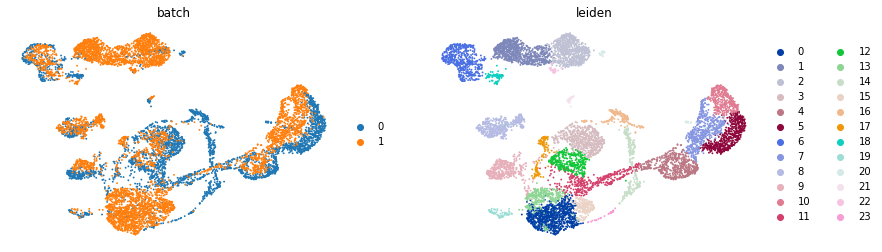

<IPython.core.display.Javascript object>

In [16]:
sc.pl.umap(adata, color=["batch", "leiden"], frameon=False)

Because this combination of datasets is used for benchmarking purposes, we have access here to curated annotations. We can use those to assess whether the harmonization worked reasonably well. 

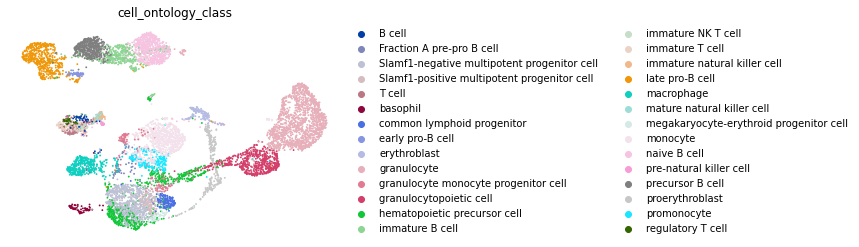

<IPython.core.display.Javascript object>

In [17]:
sc.pl.umap(adata, color=["cell_ontology_class"], frameon=False)

From a quick glance, it looks like the harmonization worked well. Indeed, the two datasets are relatively mixed in latent space and the cell types cluster together. A more refined analysis may be done at the level of markers, we refer to the BBKNN notebook for further details

### Transfer of Annotations with scANVI

We now investigate a different although complementary problem. Previously, we used scVI as we assumed we did not have any cell type annotation available to guide us. Consequently, one would need to use marker genes in order to annotate the clusters from the previous analysis. 

Now, we assume that one dataset plays the role of the reference data, with known labels, and one is the query. We will use scANVI to transfer our cell type knowledge from the reference to the query data. For this, we simply need to indicate to indicate to scANVI:
+ the sample identifier for each cell (as in scVI)
+ the cell type, or an unnassigned label for each cell


#### scANVI lables
We assume that the Smartseq2 data is annotated and the 10X data is not. We then subsample the labels so that each cell type is more or less equally represented by setting a maximum number of labelled cell (here set to 100). Only the labels of the labelled cells from the labelled Smartseq2 dataset will be kept in the adata.obs column 'celltype_scanvi', all other cells will have 'celltype_scanvi' of value 'Unknown'. 

In [18]:
labels = np.repeat("Unknown", adata.shape[0])
labels = labels.astype("<U43")
for x in np.unique(adata.obs.cell_ontology_class):
    idx = np.where((adata.obs.cell_ontology_class == x) & (adata.obs["batch"] == "1"))[
        0
    ]
    sampled = np.random.choice(idx, np.min([100, len(idx)]))
    labels[sampled] = adata.obs.cell_ontology_class[sampled]

adata.obs["celltype_scanvi"] = labels

<IPython.core.display.Javascript object>

In [19]:
np.unique(adata.obs["celltype_scanvi"])

array(['B cell', 'Slamf1-negative multipotent progenitor cell',
       'Slamf1-positive multipotent progenitor cell', 'Unknown',
       'basophil', 'common lymphoid progenitor', 'granulocyte',
       'granulocyte monocyte progenitor cell', 'granulocytopoietic cell',
       'hematopoietic precursor cell', 'immature B cell',
       'immature NK T cell', 'immature T cell',
       'immature natural killer cell', 'late pro-B cell', 'macrophage',
       'mature natural killer cell',
       'megakaryocyte-erythroid progenitor cell', 'monocyte',
       'naive B cell', 'pre-natural killer cell', 'precursor B cell',
       'regulatory T cell'], dtype=object)

<IPython.core.display.Javascript object>

Now we may register the AnnData object and run scANVI

In [20]:
scvi.dataset.setup_anndata(
    adata, batch_key="batch", labels_key="celltype_scanvi", X_layers_key="counts"
)

[2020-09-09 21:38:44,997] INFO - scvi.dataset._anndata | Using batches from adata.obs["batch"]
[2020-09-09 21:38:44,999] INFO - scvi.dataset._anndata | Using labels from adata.obs["celltype_scanvi"]
[2020-09-09 21:38:45,003] INFO - scvi.dataset._anndata | Using data from adata.layers["counts"]
[2020-09-09 21:38:45,080] INFO - scvi.dataset._anndata | Computing library size prior per batch
[2020-09-09 21:38:45,173] INFO - scvi.dataset._anndata | Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']
[2020-09-09 21:38:45,175] INFO - scvi.dataset._anndata | Successfully registered anndata object containing 8689 cells, 2000 genes, 2 batches, and 0 proteins.


<IPython.core.display.Javascript object>

In [21]:
lvae = scvi.models.SCANVI(adata, "Unknown", use_cuda=True, n_latent=30, n_layers=2)

<IPython.core.display.Javascript object>

In [22]:
lvae.train(n_epochs_semisupervised=100)

[2020-09-09 21:38:45,464] INFO - scvi.core.trainers.inference | KL warmup for 400 epochs
training: 100%|██████████| 400/400 [06:30<00:00,  1.03it/s]
[2020-09-09 21:45:16,293] INFO - scvi.core.trainers.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
[2020-09-09 21:45:16,295] INFO - scvi.core.trainers.inference | KL warmup for 400 epochs
training: 100%|██████████| 100/100 [04:08<00:00,  2.48s/it]
[2020-09-09 21:49:24,311] INFO - scvi.core.trainers.inference | Training is still in warming up phase. If your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.


<IPython.core.display.Javascript object>

Now we can predict the missing cell types, and get the latent space

In [23]:
adata.obs["C_scANVI"] = lvae.predict(adata)
adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)

<IPython.core.display.Javascript object>

Again, we may visualize the latent space as well as the inferred labels

In [24]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)

<IPython.core.display.Javascript object>

... storing 'celltype_scanvi' as categorical
... storing 'C_scANVI' as categorical


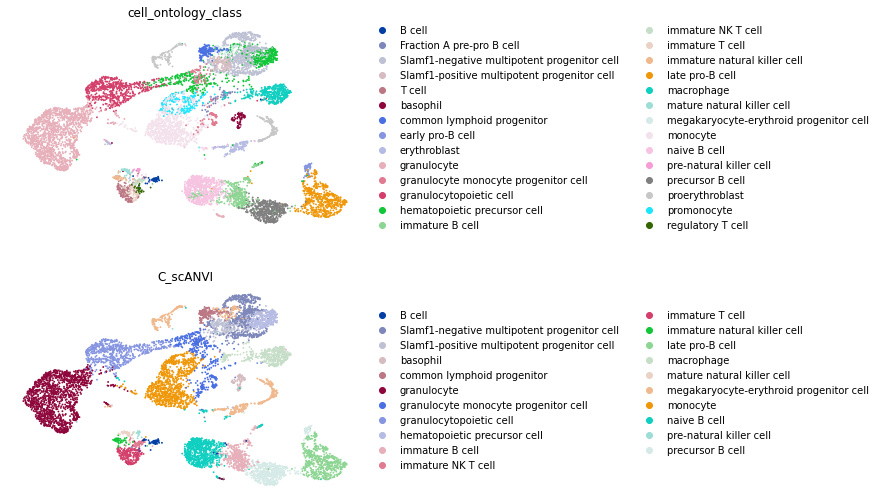

<IPython.core.display.Javascript object>

In [25]:
sc.pl.umap(adata, color=["cell_ontology_class", "C_scANVI"], ncols=1, frameon=False)

In [48]:
confusion_matrix = dict()
for x in np.unique(adata[adata.obs.batch.astype(int) == 0].obs.cell_ontology_class):
    confusion_matrix[x] = dict()
    for y in np.unique(adata[adata.obs.batch.astype(int) == 0].obs.C_scANVI):
        confusion_matrix[x][y] = 0

for x, y in zip(
    adata[adata.obs.batch.astype(int) == 0].obs["cell_ontology_class"],
    adata[adata.obs.batch.astype(int) == 0].obs["C_scANVI"],
):
    confusion_matrix[x][y] += 1

<IPython.core.display.Javascript object>

In [49]:
confusion_matrix = pd.DataFrame.from_dict(confusion_matrix)
confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=0)

<IPython.core.display.Javascript object>

([<matplotlib.axis.XTick at 0x7f51042c0208>,
 [Text(0, 0, 'Fraction A pre-pro B cell'),
  Text(0, 0, 'T cell'),
  Text(0, 0, 'basophil'),
  Text(0, 0, 'early pro-B cell'),
  Text(0, 0, 'erythroblast'),
  Text(0, 0, 'granulocyte'),
  Text(0, 0, 'granulocytopoietic cell'),
  Text(0, 0, 'hematopoietic precursor cell'),
  Text(0, 0, 'immature B cell'),
  Text(0, 0, 'late pro-B cell'),
  Text(0, 0, 'macrophage'),
  Text(0, 0, 'monocyte'),
  Text(0, 0, 'proerythroblast'),
  Text(0, 0, 'promonocyte')])

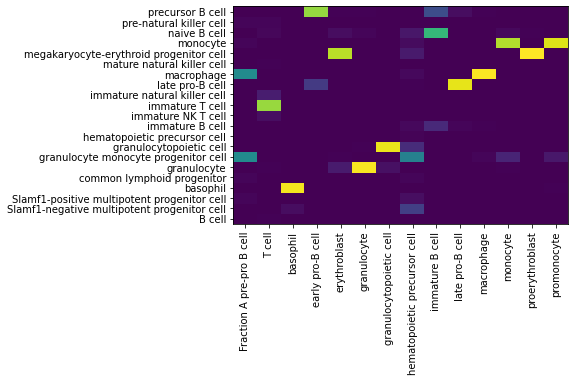

<IPython.core.display.Javascript object>

In [53]:
plt.pcolor(confusion_matrix)
plt.yticks(np.arange(0.5, len(confusion_matrix.index), 1), confusion_matrix.index)
plt.xticks(np.arange(0.5, len(confusion_matrix.columns), 1), confusion_matrix.columns, rotation=90)


As we see in this, scANVI's latent space separates all cell types and performs well at classifying major cell types. Since the 10X data is labelled at lower resolution, the transferred labels are not always identical with the original label. However biologically the transferred labels are subsets of the original labels. 

Ready to learn more? Dig into our [documentation](https://scvi.readthedocs.io/en/stable/)!